# Loss‑by‑Loss Report: Simulated Multi‑Omics Caption Training
This notebook is a structured ‘lab report’ that **simulates** four different caption‑style datasets, previews each one, and then trains a separate Sentence‑Transformer run **per loss function**.

You can execute the notebook top‑to‑bottom or jump to the section of the loss you are interested in.

*Auto‑generated on 2025-05-15 14:22*

In [169]:
%load_ext autoreload
%autoreload 2
from mmcontext.utils import setup_logging

logger = setup_logging()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Environment setup & shared helpers

In [170]:
import logging
import os
import platform
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from tqdm.autonotebook import tqdm

from mmcontext.mmcontextencoder import MMContextEncoder
from mmcontext.sanity_helpers import cluster_variances, plot_pca, stack_embeddings  # provided separately
from mmcontext.simulator import OmicsCaptionSimulator, make_cluster_sampler

# ---------------------------------------------------------------------
# Logger
# ---------------------------------------------------------------------
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


# ---------------------------------------------------------------------
# Optional: pick a device smartly (work‑around for MPS bug)
# ---------------------------------------------------------------------
def choose_device():
    """Return the best available torch.device for training."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if platform.system() == "Darwin" and torch.backends.mps.is_available():
        # Avoid the 'placeholder tensor is empty' MPS assert seen with some triplet losses
        os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
        return torch.device("cpu")
    return torch.device("cpu")


DEVICE = choose_device()
logger.info("Using device: %s", DEVICE)


# ---------------------------------------------------------------------
# Helper: output directory per loss
# ---------------------------------------------------------------------
def get_output_dir(base: str, loss_name: str) -> Path:
    """Create & return `base/loss_YYYYMMDD_HHMMSS`."""
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = Path(base) / f"{loss_name}_{stamp}"
    out.mkdir(parents=True, exist_ok=True)
    return out


# ---------------------------------------------------------------------
# Helper: plot training loss from Trainer log history
# ---------------------------------------------------------------------
def plot_training_loss(trainer, title: str = "Training loss history"):
    """Extract 'loss' or 'train_loss' from Trainer.state.log_history and plot."""
    steps, vals = [], []
    for h in trainer.state.log_history:
        key = "loss" if "loss" in h else "train_loss" if "train_loss" in h else None
        if key:
            steps.append(h.get("step", len(steps)))
            vals.append(h[key])
    if not steps:
        logger.warning("No loss values found in Trainer log history – maybe increase `logging_steps`.")
        return
    plt.figure()
    plt.plot(steps, vals, marker="o")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

2025-05-16 16:01:29,320 - __main__ - INFO - Using device: cpu


In [171]:
# Fixed ST training hyper‑parameters
BASE_OUTDIR = "./models/demo_random"
TRAIN_KW = {
    "num_train_epochs": 2,
    "per_device_train_batch_size": 128,
    "per_device_eval_batch_size": 128,
    "learning_rate": 1e-2,
    "logging_steps": 1,
    "report_to": "wandb",
}

## 2. Simulate captioning datasets

In [172]:
N_SAMPLES = 5000
NOISE = 0.2
BATCH_SHIFT = 0.8
rng_seed = 42

logger.info("Simulating omics caption data …")
sim = OmicsCaptionSimulator(n_samples=N_SAMPLES, numeric_sampler=None).simulate()

cell_types = list(sim.adata.obs["cell_type"])
assays = list(sim.adata.obs["assay"])
sim.numeric_sampler = make_cluster_sampler(labels=cell_types, batch_labels=assays, noise=NOISE, batch_shift=BATCH_SHIFT)
sim._build_embeddings()

gene_df, sample_df = sim.get_dataframes()
logger.info("gene_df shape: %s ; sample_df shape: %s", gene_df.shape, sample_df.shape)

# Build all four presets
presets = ["pair", "triplet", "pair-binary", "single-class"]
hf_datasets = {}
for p in presets:
    sim._build_hf_dataset(preset=p)
    hf_datasets[p] = sim.get_hf_dataset()
    logger.info("Preset '%s' ready. Columns: %s", p, hf_datasets[p]["train"].column_names)

2025-05-16 16:01:29,370 - __main__ - INFO - Simulating omics caption data …
Filter: 100%|██████████| 10000/10000 [00:00<00:00, 708329.79 examples/s]
2025-05-16 16:01:33,928 - __main__ - INFO - gene_df shape: (1000, 2) ; sample_df shape: (5000, 2)
Filter: 100%|██████████| 5000/5000 [00:00<00:00, 760471.41 examples/s]
2025-05-16 16:01:34,525 - __main__ - INFO - Preset 'pair' ready. Columns: ['sentence1', 'sentence2', 'sample_idx']
Filter: 100%|██████████| 5000/5000 [00:00<00:00, 597717.61 examples/s]
2025-05-16 16:01:36,591 - __main__ - INFO - Preset 'triplet' ready. Columns: ['anchor', 'positive', 'negative', 'sample_idx']
Filter: 100%|██████████| 10000/10000 [00:00<00:00, 752274.06 examples/s]
2025-05-16 16:01:41,376 - __main__ - INFO - Preset 'pair-binary' ready. Columns: ['sentence1', 'sentence2', 'label', 'sample_idx']
Filter: 100%|██████████| 5000/5000 [00:00<00:00, 914349.49 examples/s]
2025-05-16 16:01:41,971 - __main__ - INFO - Preset 'single-class' ready. Columns: ['sentence', 

### 2.1 Dataset preview

In [173]:
for preset, ds in hf_datasets.items():
    print("\n---", preset, "---")
    display(pd.DataFrame(ds["train"][:5]))


--- pair ---


sentence1   sentence2 sample_idx
0  sample_idx:S1      Neuron         S1
1  sample_idx:S2  Fibroblast         S2
2  sample_idx:S3  Epithelial         S3
3  sample_idx:S4     NK cell         S4
4  sample_idx:S7      T cell         S7


--- triplet ---


anchor    positive          negative sample_idx
0  sample_idx:S2  Fibroblast  sample_idx:S1329         S2
1  sample_idx:S3  Epithelial  sample_idx:S1852         S3
2  sample_idx:S4     NK cell  sample_idx:S3178         S4
3  sample_idx:S5  Macrophage   sample_idx:S845         S5
4  sample_idx:S6      T cell   sample_idx:S295         S6


--- pair-binary ---


sentence1       sentence2  label sample_idx
0  sample_idx:S1          Neuron      1         S1
1  sample_idx:S1          T cell      0         S1
2  sample_idx:S2      Fibroblast      1         S2
3  sample_idx:S2  Dendritic cell      0         S2
4  sample_idx:S4         NK cell      1         S4


--- single-class ---


sentence  label sample_idx
0  sample_idx:S1      8         S1
1  sample_idx:S2      5         S2
2  sample_idx:S3      4         S3
3  sample_idx:S5      6         S5
4  sample_idx:S6      9         S6

<Axes: title={'center': 'Simulated data (original) - batches'}, xlabel='PC1', ylabel='PC2'>

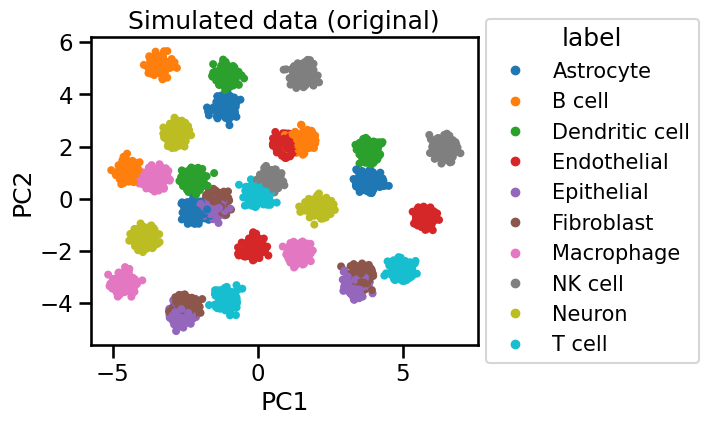

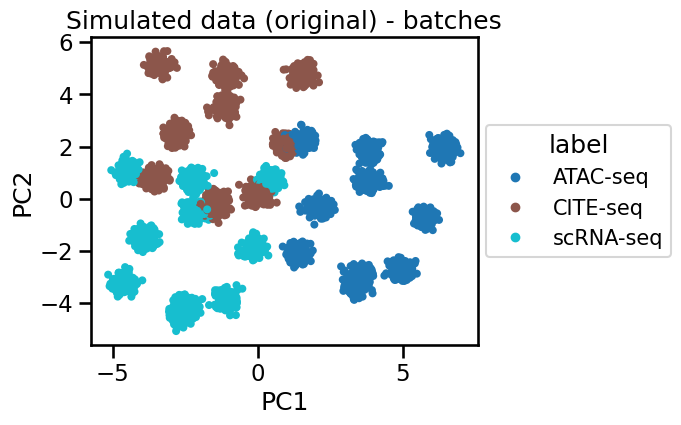

In [174]:
from mmcontext.sanity_helpers import class_scatter

# plot distribtion of simulated data
old_emb = stack_embeddings(sample_df)
old_labels = sim.adata.obs["cell_type"].tolist()
batch_labels = sim.adata.obs["assay"].tolist()
plot_pca(old_emb, old_labels, title="Simulated data (original)", legend_out=True)
plot_pca(old_emb, batch_labels, title="Simulated data (original) - batches", legend_out=True)
# class_scatter(old_emb, old_labels)

## 3. Initialise `MMContextEncoder` & obtain baseline embeddings

In [175]:
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=10,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
st_base = SentenceTransformer(modules=[enc]).to(DEVICE)

2025-05-16 16:01:42,458 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 16:01:42,459 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 16:01:42,461 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


## 4.1 MultipleNegativesRankingLoss
The **Multiple‑Negatives Ranking Loss** treats every other sentence in the same batch as a negative example, making it memory‑efficient for large vocabularies.

*Dataset used:* **pair**

In [176]:
# --- MultipleNegativesRankingLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence1   sentence2 sample_idx
0  sample_idx:S1      Neuron         S1
1  sample_idx:S2  Fibroblast         S2
2  sample_idx:S3  Epithelial         S3
3  sample_idx:S4     NK cell         S4
4  sample_idx:S7      T cell         S7

2025-05-16 16:01:43,419 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 16:01:43,420 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 16:01:43,422 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 27%|██▋       | 17/64 [00:00<00:00, 81.69it/s]                      

{'loss': 4.8489, 'grad_norm': 0.053998950868844986, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 4.8274, 'grad_norm': 0.04866452142596245, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 4.809, 'grad_norm': 0.04650089144706726, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 4.7927, 'grad_norm': 0.04361635446548462, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 4.7735, 'grad_norm': 0.038357656449079514, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 4.763, 'grad_norm': 0.03545230254530907, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 4.7472, 'grad_norm': 0.033043742179870605, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 4.7397, 'grad_norm': 0.030342379584908485, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 4.7303, 'grad_norm': 0.027013208717107773, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 4.7237, 'grad_norm': 0.0251755453646183, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 4.717, 'grad_norm': 0.023222640156745

 55%|█████▍    | 35/64 [00:00<00:00, 85.65it/s]

{'loss': 4.6903, 'grad_norm': 0.013748422265052795, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 4.6882, 'grad_norm': 0.01241806149482727, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 4.6861, 'grad_norm': 0.011796305887401104, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 4.6854, 'grad_norm': 0.01088497694581747, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 4.6843, 'grad_norm': 0.010879799723625183, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 4.6825, 'grad_norm': 0.009987019002437592, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 4.6824, 'grad_norm': 0.01036129891872406, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 4.68, 'grad_norm': 0.009234783239662647, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 4.6794, 'grad_norm': 0.008529268205165863, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 4.6783, 'grad_norm': 0.008690859191119671, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 4.6777, 'grad_norm': 0.0080403527

 83%|████████▎ | 53/64 [00:00<00:00, 86.73it/s]

{'loss': 4.6738, 'grad_norm': 0.005879858508706093, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 4.6733, 'grad_norm': 0.0057481927797198296, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 4.6724, 'grad_norm': 0.005462439730763435, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 4.6731, 'grad_norm': 0.0055641052313148975, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 4.6722, 'grad_norm': 0.005212981719523668, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 4.672, 'grad_norm': 0.005289668217301369, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 4.6719, 'grad_norm': 0.005263390019536018, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 4.6713, 'grad_norm': 0.004784185905009508, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 4.6716, 'grad_norm': 0.004750242922455072, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 4.6716, 'grad_norm': 0.004757984541356564, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 4.6715, 'grad_norm': 0.0047173588536679

100%|██████████| 64/64 [00:00<00:00, 87.39it/s]2025-05-16 16:01:44,461 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/multiplenegativesrankingloss_20250516_160143/checkpoint-64
2025-05-16 16:01:44,462 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/multiplenegativesrankingloss_20250516_160143/checkpoint-64


{'loss': 4.6705, 'grad_norm': 0.004164980724453926, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 4.6707, 'grad_norm': 0.004165899474173784, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 4.6706, 'grad_norm': 0.003952851518988609, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 4.6711, 'grad_norm': 0.003981162793934345, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 4.6702, 'grad_norm': 0.004025390837341547, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 4.6702, 'grad_norm': 0.0038707642816007137, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 4.6703, 'grad_norm': 0.00375579996034503, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 4.6704, 'grad_norm': 0.004092500079423189, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 4.6704, 'grad_norm': 0.004035603255033493, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 4.6703, 'grad_norm': 0.0037598079070448875, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 3.288, 'grad_norm': 0.0055979066528379

100%|██████████| 64/64 [00:01<00:00, 36.53it/s]

{'train_runtime': 1.753, 'train_samples_per_second': 4563.68, 'train_steps_per_second': 36.509, 'train_loss': 4.650350879877806, 'epoch': 2.0}


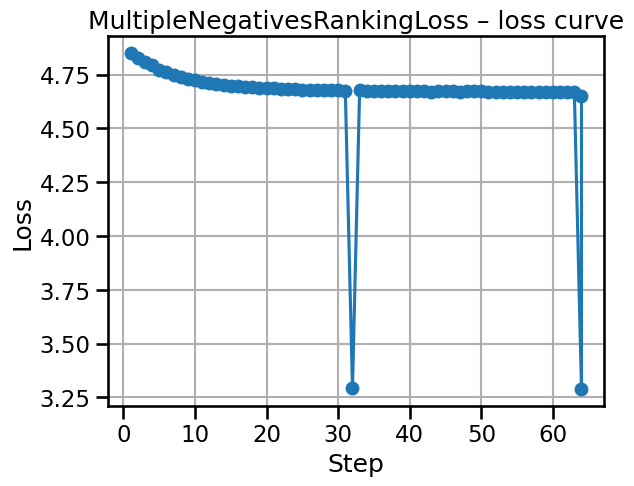

In [177]:
# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.MultipleNegativesRankingLoss
loss_fn = loss_cls(model, scale=0.2).to(DEVICE)

out_dir = get_output_dir("./models/report", "multiplenegativesrankingloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="multiplenegativesrankingloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="MultipleNegativesRankingLoss – loss curve")

initial  : within=0.4421   between=0.9680   sil=0.620
trained  : within=0.0275   between=0.9633   sil=0.971
trained2 : within=0.0000   between=0.9235   sil=1.000


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

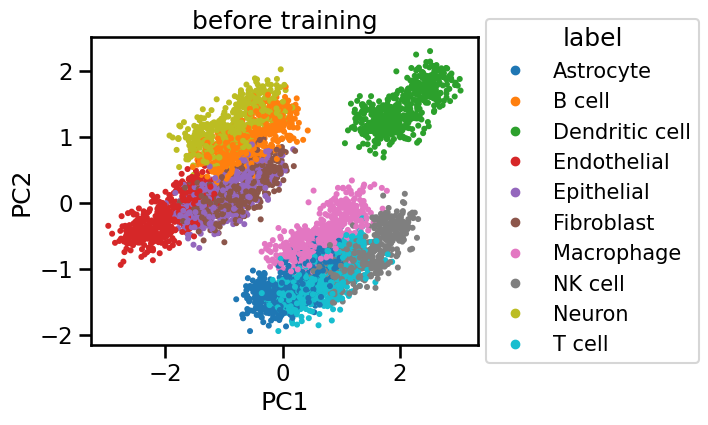

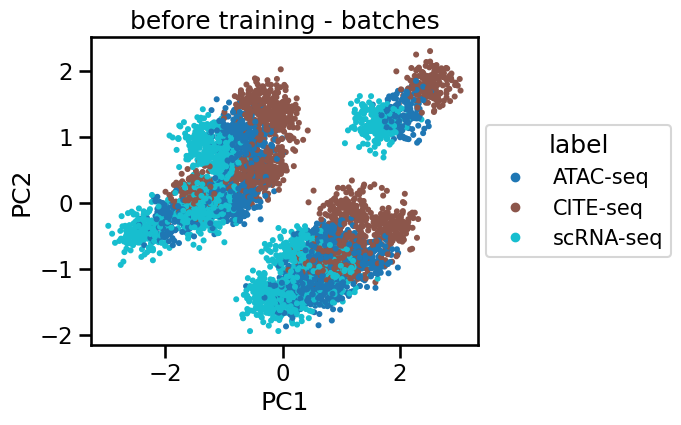

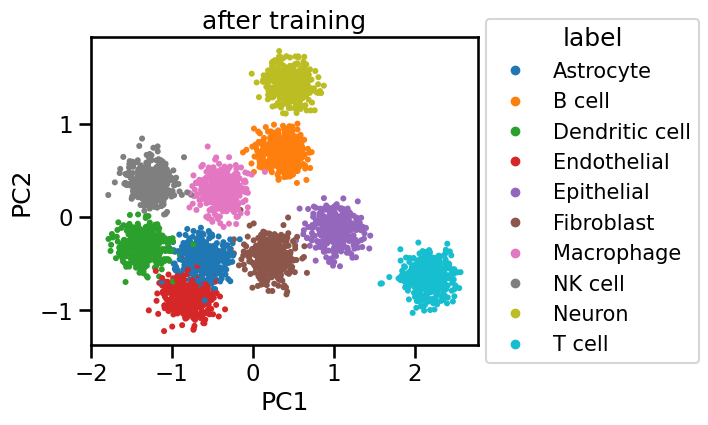

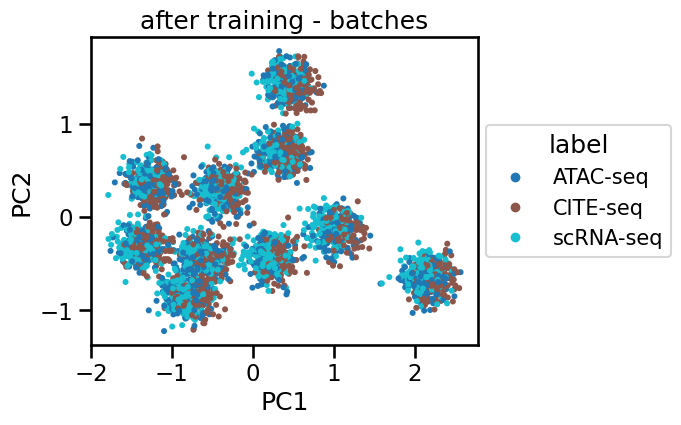

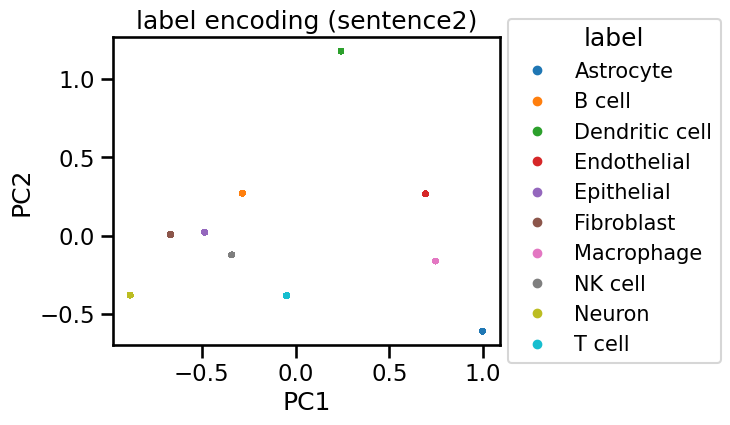

In [178]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}   sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}   sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.2 MultipleNegativesSymmetricRankingLoss
A symmetric variant that pushes both anchor→positive and positive→anchor.

*Dataset used:* **pair**

In [179]:
# --- MultipleNegativesSymmetricRankingLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence1   sentence2 sample_idx
0  sample_idx:S1      Neuron         S1
1  sample_idx:S2  Fibroblast         S2
2  sample_idx:S3  Epithelial         S3
3  sample_idx:S4     NK cell         S4
4  sample_idx:S7      T cell         S7

2025-05-16 16:01:47,406 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 16:01:47,407 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 16:01:47,409 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 27%|██▋       | 17/64 [00:00<00:00, 82.22it/s]                      

{'loss': 7.2385, 'grad_norm': 6.28831148147583, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 4.8279, 'grad_norm': 4.6276750564575195, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 3.3527, 'grad_norm': 2.648146867752075, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 2.794, 'grad_norm': 0.8090804815292358, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 2.6348, 'grad_norm': 0.3320668339729309, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 2.6389, 'grad_norm': 0.3656691014766693, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 2.6035, 'grad_norm': 0.23367951810359955, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 2.62, 'grad_norm': 0.30483636260032654, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 2.6188, 'grad_norm': 0.259942889213562, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 2.6325, 'grad_norm': 0.2931945323944092, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 2.5962, 'grad_norm': 0.21569077670574188, 'learning_ra

 55%|█████▍    | 35/64 [00:00<00:00, 85.74it/s]

{'loss': 2.6038, 'grad_norm': 0.14714230597019196, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 2.6034, 'grad_norm': 0.11129187047481537, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 2.5862, 'grad_norm': 0.12315788120031357, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 2.6492, 'grad_norm': 0.24406075477600098, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 2.6364, 'grad_norm': 0.17652671039104462, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 2.5961, 'grad_norm': 0.10563541203737259, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 2.622, 'grad_norm': 0.10379654914140701, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 2.5874, 'grad_norm': 0.08716387301683426, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 2.5961, 'grad_norm': 0.13194556534290314, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 2.6122, 'grad_norm': 0.11045815050601959, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 2.5941, 'grad_norm': 0.2195790559053421

 83%|████████▎ | 53/64 [00:00<00:00, 86.51it/s]

{'loss': 2.6064, 'grad_norm': 0.1699846088886261, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 2.5866, 'grad_norm': 0.13072636723518372, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 2.5755, 'grad_norm': 0.16609816253185272, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 2.6117, 'grad_norm': 0.15585286915302277, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 2.5975, 'grad_norm': 0.13327708840370178, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 2.5906, 'grad_norm': 0.07586515694856644, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 2.6047, 'grad_norm': 0.1586892008781433, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 2.5892, 'grad_norm': 0.15893030166625977, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 2.5861, 'grad_norm': 0.07062040269374847, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 2.5934, 'grad_norm': 0.0854511559009552, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 2.598, 'grad_norm': 0.0633324682712555, 'learning_rat

100%|██████████| 64/64 [00:00<00:00, 83.71it/s]2025-05-16 16:01:48,444 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/multiplenegativessymmetricrankingloss_20250516_160147/checkpoint-64
2025-05-16 16:01:48,444 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/multiplenegativessymmetricrankingloss_20250516_160147/checkpoint-64


{'loss': 2.5919, 'grad_norm': 0.10073204338550568, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 2.6027, 'grad_norm': 0.07149471342563629, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 2.6068, 'grad_norm': 0.16572028398513794, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 2.5962, 'grad_norm': 0.070414699614048, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 2.6033, 'grad_norm': 0.0691545233130455, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 2.5832, 'grad_norm': 0.08717549592256546, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 2.5911, 'grad_norm': 0.07230279594659805, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 2.6079, 'grad_norm': 0.08331391960382462, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 2.6107, 'grad_norm': 0.06625282019376755, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 2.5945, 'grad_norm': 0.1065768226981163, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 1.3194, 'grad_norm': 0.22191636264324188, 'learning_r

100%|██████████| 64/64 [00:01<00:00, 36.20it/s]

{'train_runtime': 1.7686, 'train_samples_per_second': 4523.224, 'train_steps_per_second': 36.186, 'train_loss': 2.6834378372877836, 'epoch': 2.0}


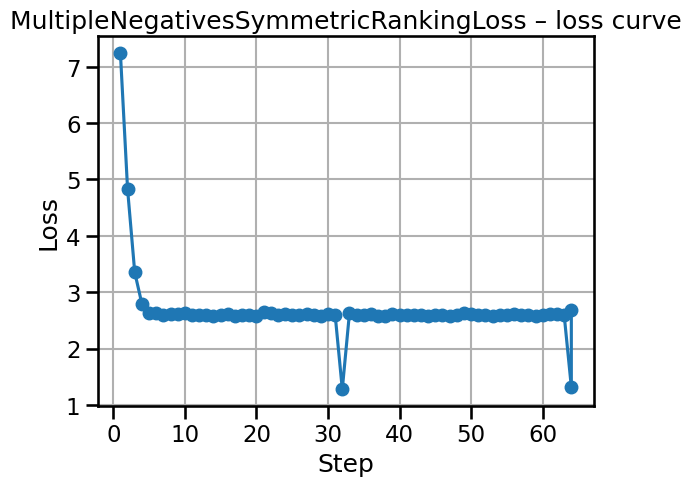

In [180]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.MultipleNegativesSymmetricRankingLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "multiplenegativessymmetricrankingloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="multiplenegativessymmetricrankingloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="MultipleNegativesSymmetricRankingLoss – loss curve")

initial  : within=0.4421   between=0.9680  sil=0.620
trained  : within=0.1154   between=0.9105   sil=0.855
trained2 : within=0.0000   between=0.9536    sil=1.000


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

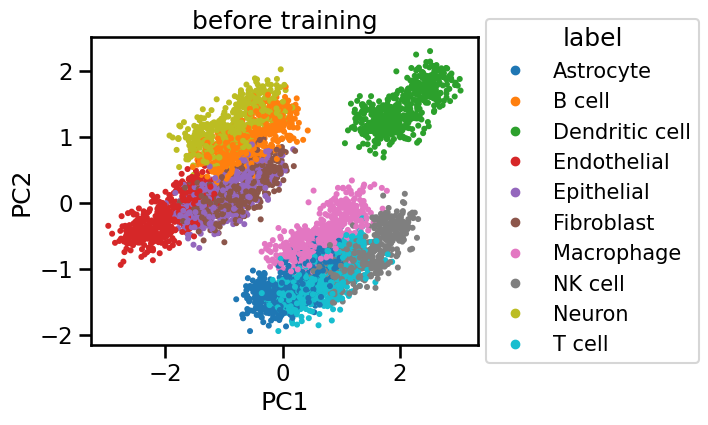

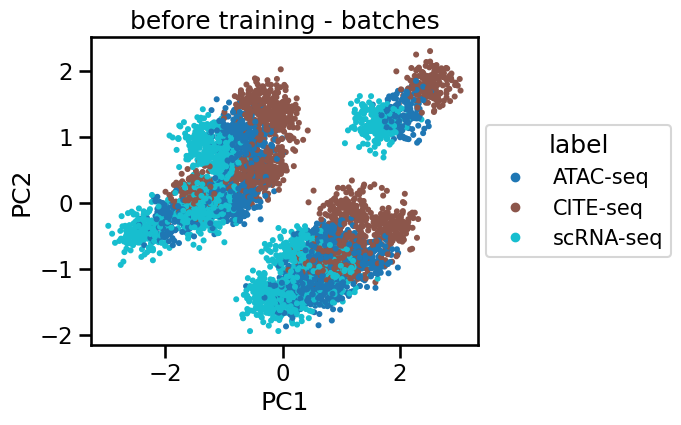

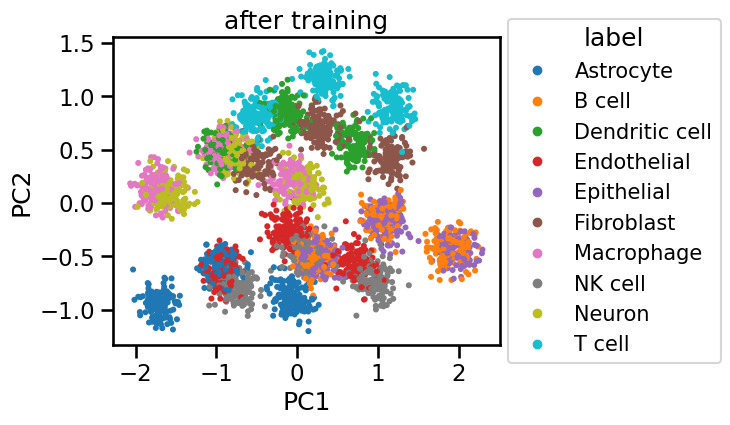

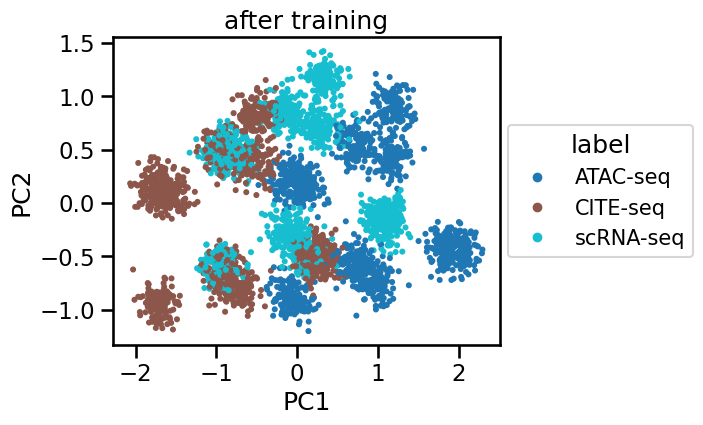

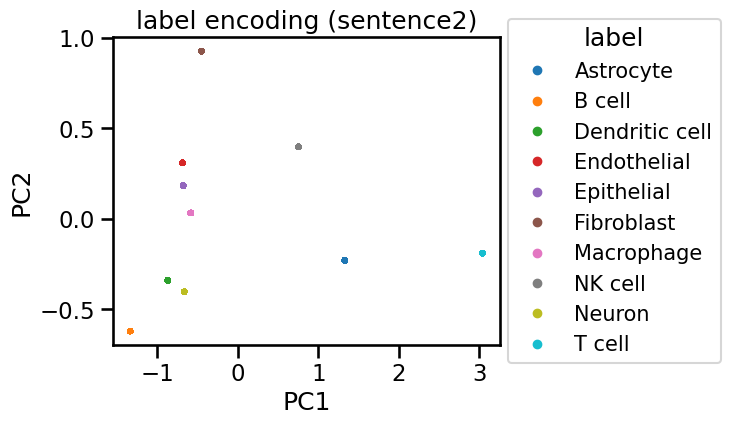

In [181]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}  sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}    sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.3 TripletLoss
Classic **triplet margin loss** with explicit anchor/positive/negative examples.

*Dataset used:* **triplet**

In [143]:
# --- TripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["triplet"]["train"]
display(pd.DataFrame(train_ds[:5]))

anchor    positive          negative sample_idx
0  sample_idx:S2  Fibroblast  sample_idx:S1329         S2
1  sample_idx:S3  Epithelial  sample_idx:S1852         S3
2  sample_idx:S4     NK cell  sample_idx:S3178         S4
3  sample_idx:S5  Macrophage   sample_idx:S845         S5
4  sample_idx:S6      T cell   sample_idx:S295         S6

2025-05-16 15:47:56,412 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:47:56,413 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:47:56,414 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 17%|█▋        | 11/64 [00:00<00:00, 53.03it/s]                      

{'loss': 5.7842, 'grad_norm': 2.1965978145599365, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 4.3144, 'grad_norm': 2.3642947673797607, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 3.6412, 'grad_norm': 2.242446184158325, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 2.5422, 'grad_norm': 1.9089475870132446, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 2.1177, 'grad_norm': 1.7446484565734863, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 1.9502, 'grad_norm': 1.6397700309753418, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 1.4508, 'grad_norm': 1.2827553749084473, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.745, 'grad_norm': 0.9166887402534485, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.9718, 'grad_norm': 0.6844425201416016, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.808, 'grad_norm': 0.548785924911499, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.7712, 'grad_norm': 0.4193917512893677, 'learning_ra

 36%|███▌      | 23/64 [00:00<00:00, 56.29it/s]

{'loss': 0.5729, 'grad_norm': 0.33864739537239075, 'learning_rate': 0.008125, 'epoch': 0.38}
{'loss': 0.606, 'grad_norm': 0.39927971363067627, 'learning_rate': 0.00796875, 'epoch': 0.41}
{'loss': 0.7535, 'grad_norm': 0.43962356448173523, 'learning_rate': 0.0078125, 'epoch': 0.44}
{'loss': 0.6612, 'grad_norm': 0.29873111844062805, 'learning_rate': 0.00765625, 'epoch': 0.47}
{'loss': 0.5545, 'grad_norm': 0.24467529356479645, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 0.5842, 'grad_norm': 0.3189648687839508, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.3365, 'grad_norm': 0.2719334661960602, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.4386, 'grad_norm': 0.28021469712257385, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.5665, 'grad_norm': 0.25348222255706787, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.6376, 'grad_norm': 0.3517785370349884, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.6478, 'grad_norm': 0.3259999454021454, 'lea

 55%|█████▍    | 35/64 [00:00<00:00, 56.37it/s]

{'loss': 0.522, 'grad_norm': 0.2350872904062271, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.4718, 'grad_norm': 0.30472835898399353, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.4588, 'grad_norm': 0.24070826172828674, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.7275, 'grad_norm': 0.4105669856071472, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.3535, 'grad_norm': 0.35279491543769836, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.6948, 'grad_norm': 0.2743489444255829, 'learning_rate': 0.0054687500000000005, 'epoch': 0.91}
{'loss': 0.6252, 'grad_norm': 0.4030064046382904, 'learning_rate': 0.0053125, 'epoch': 0.94}
{'loss': 0.6766, 'grad_norm': 0.23907199501991272, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 0.4605, 'grad_norm': 0.4693641662597656, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.3174, 'grad_norm': 0.21468397974967957, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.5511, 'grad_norm': 0.3115391135215759, 'learnin

 75%|███████▌  | 48/64 [00:00<00:00, 57.98it/s]

{'loss': 0.4046, 'grad_norm': 0.3262035846710205, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.3498, 'grad_norm': 0.2445880025625229, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.6501, 'grad_norm': 0.31776654720306396, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0362, 'grad_norm': 0.12525413930416107, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.621, 'grad_norm': 0.21207065880298615, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.4271, 'grad_norm': 0.2680318355560303, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.6081, 'grad_norm': 0.2553347647190094, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.7363, 'grad_norm': 0.2599201500415802, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.2139, 'grad_norm': 0.20926335453987122, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.1524, 'grad_norm': 0.182718887925148, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 0.249, 'grad_norm': 0.22235700488090515, 'learning_rate': 

 94%|█████████▍| 60/64 [00:01<00:00, 61.20it/s]

{'loss': 0.6665, 'grad_norm': 0.24117690324783325, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.3208, 'grad_norm': 0.27902865409851074, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.2311, 'grad_norm': 0.20856551826000214, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.3851, 'grad_norm': 0.19463907182216644, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.3943, 'grad_norm': 0.22668679058551788, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.3294, 'grad_norm': 0.1651337593793869, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.2518, 'grad_norm': 0.20073936879634857, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.1681, 'grad_norm': 0.15620197355747223, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.2896, 'grad_norm': 0.2166602462530136, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.3967, 'grad_norm': 0.19303376972675323, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.3783, 'grad_norm': 0.21564292907714844, 'learning

100%|██████████| 64/64 [00:01<00:00, 58.86it/s]2025-05-16 15:47:57,826 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/tripletloss_20250516_154756/checkpoint-64
2025-05-16 15:47:57,827 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/tripletloss_20250516_154756/checkpoint-64


{'loss': 0.2524, 'grad_norm': 0.13715757429599762, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 0.158, 'grad_norm': 0.17564351856708527, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 0.2345, 'grad_norm': 0.24097338318824768, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 29.89it/s]

{'train_runtime': 2.1429, 'train_samples_per_second': 3733.292, 'train_steps_per_second': 29.866, 'train_loss': 0.7615812232834287, 'epoch': 2.0}


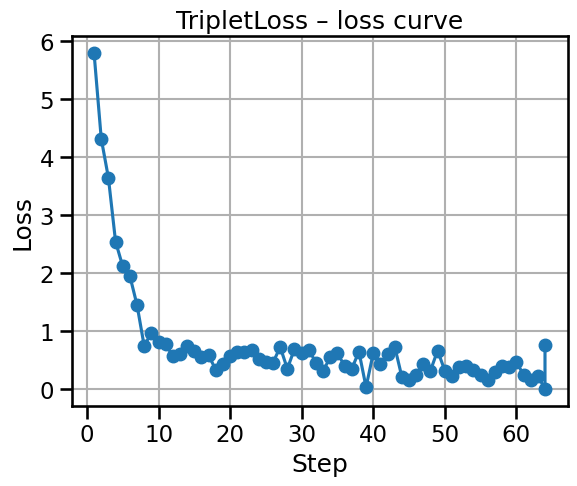

In [144]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.TripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "tripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="tripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="TripletLoss – loss curve")

initial  : within=0.4421   between=0.9680  sil=0.620
trained  : within=0.4405   between=0.9057   sil=0.642
trained2 : within=0.0000   between=0.9311  sil=1.000


<Axes: title={'center': 'label encoding (positive)'}, xlabel='PC1', ylabel='PC2'>

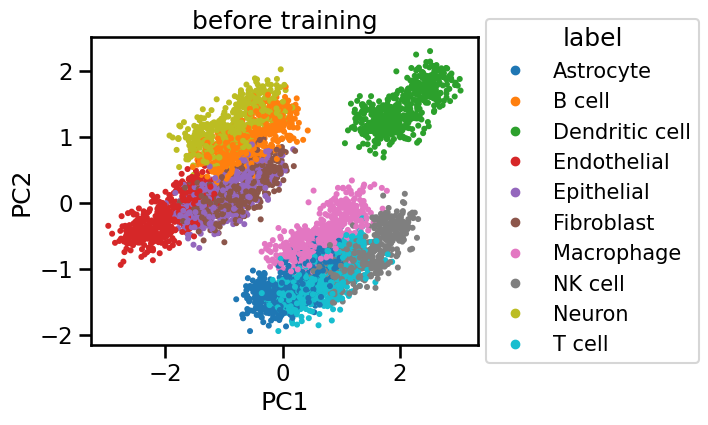

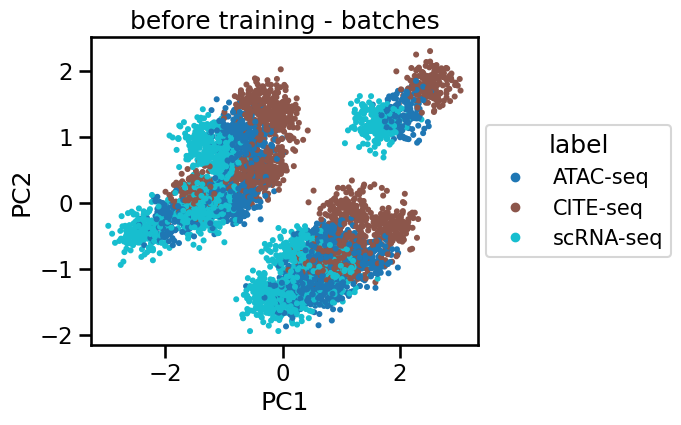

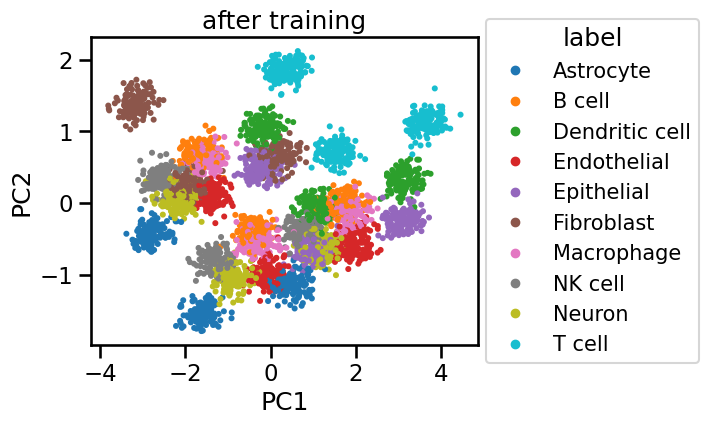

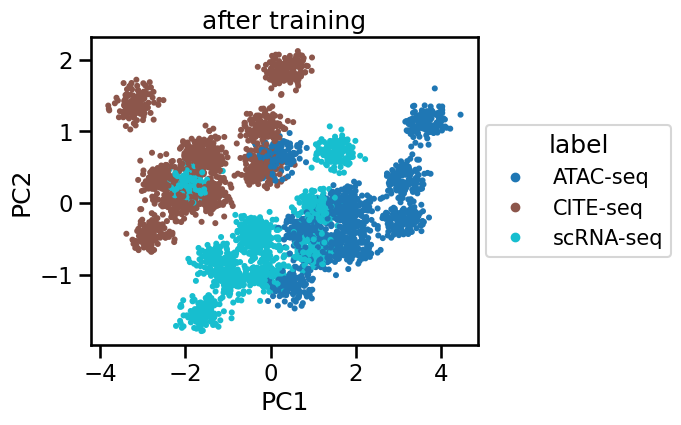

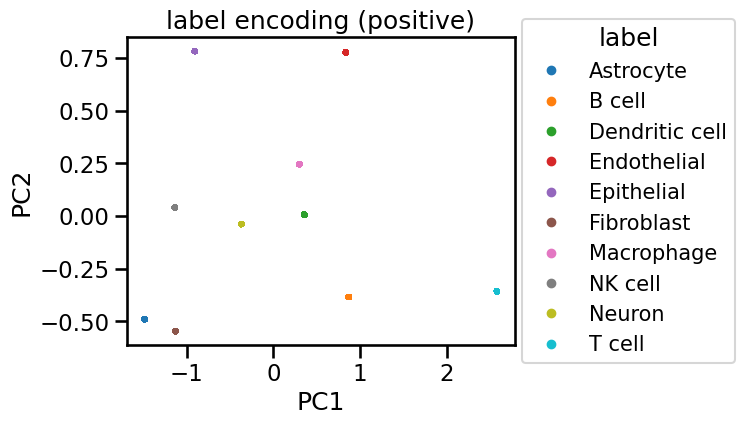

In [145]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset triplet")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["positive"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}  sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}  sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (positive)", point_size=8, legend_out=True)

## 4.4 ContrastiveLoss
Binary‑label contrastive loss (1 = similar, 0 = dissimilar) originally from Hadsell et al., 2006.

*Dataset used:* **pair-binary**

In [146]:
# --- ContrastiveLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["pair-binary"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence1       sentence2  label sample_idx
0  sample_idx:S1          Neuron      1         S1
1  sample_idx:S1          T cell      0         S1
2  sample_idx:S2      Fibroblast      1         S2
3  sample_idx:S2  Dendritic cell      0         S2
4  sample_idx:S4         NK cell      1         S4

2025-05-16 15:48:00,846 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:48:00,847 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:48:00,849 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 13%|█▎        | 17/126 [00:00<00:01, 82.07it/s]                     

{'loss': 0.2477, 'grad_norm': 0.12966348230838776, 'learning_rate': 0.009920634920634922, 'epoch': 0.02}
{'loss': 0.2266, 'grad_norm': 0.12895534932613373, 'learning_rate': 0.009841269841269842, 'epoch': 0.03}
{'loss': 0.1561, 'grad_norm': 0.09977877885103226, 'learning_rate': 0.009761904761904762, 'epoch': 0.05}
{'loss': 0.1548, 'grad_norm': 0.09630776941776276, 'learning_rate': 0.009682539682539683, 'epoch': 0.06}
{'loss': 0.1027, 'grad_norm': 0.0696994960308075, 'learning_rate': 0.009603174603174603, 'epoch': 0.08}
{'loss': 0.0892, 'grad_norm': 0.059363510459661484, 'learning_rate': 0.009523809523809523, 'epoch': 0.1}
{'loss': 0.0747, 'grad_norm': 0.05035500228404999, 'learning_rate': 0.009444444444444445, 'epoch': 0.11}
{'loss': 0.0528, 'grad_norm': 0.03808727115392685, 'learning_rate': 0.009365079365079366, 'epoch': 0.13}
{'loss': 0.0493, 'grad_norm': 0.03528063744306564, 'learning_rate': 0.009285714285714286, 'epoch': 0.14}
{'loss': 0.0399, 'grad_norm': 0.02979356050491333, 'lear

 28%|██▊       | 35/126 [00:00<00:01, 85.27it/s]

{'loss': 0.0135, 'grad_norm': 0.008491895161569118, 'learning_rate': 0.008571428571428572, 'epoch': 0.29}
{'loss': 0.014, 'grad_norm': 0.008971993811428547, 'learning_rate': 0.008492063492063492, 'epoch': 0.3}
{'loss': 0.0127, 'grad_norm': 0.009257202036678791, 'learning_rate': 0.008412698412698413, 'epoch': 0.32}
{'loss': 0.0117, 'grad_norm': 0.007021056022495031, 'learning_rate': 0.008333333333333333, 'epoch': 0.33}
{'loss': 0.0122, 'grad_norm': 0.006565901450812817, 'learning_rate': 0.008253968253968253, 'epoch': 0.35}
{'loss': 0.0105, 'grad_norm': 0.006165655795484781, 'learning_rate': 0.008174603174603175, 'epoch': 0.37}
{'loss': 0.0111, 'grad_norm': 0.005570163484662771, 'learning_rate': 0.008095238095238096, 'epoch': 0.38}
{'loss': 0.0083, 'grad_norm': 0.0043594385497272015, 'learning_rate': 0.008015873015873016, 'epoch': 0.4}
{'loss': 0.0092, 'grad_norm': 0.0050856550224125385, 'learning_rate': 0.007936507936507936, 'epoch': 0.41}
{'loss': 0.0098, 'grad_norm': 0.005093480460345

 42%|████▏     | 53/126 [00:00<00:00, 86.18it/s]

{'loss': 0.0102, 'grad_norm': 0.0045252153649926186, 'learning_rate': 0.0071428571428571435, 'epoch': 0.57}
{'loss': 0.008, 'grad_norm': 0.004216165281832218, 'learning_rate': 0.007063492063492064, 'epoch': 0.59}
{'loss': 0.0055, 'grad_norm': 0.003181960666552186, 'learning_rate': 0.006984126984126984, 'epoch': 0.6}
{'loss': 0.0106, 'grad_norm': 0.004300168249756098, 'learning_rate': 0.006904761904761905, 'epoch': 0.62}
{'loss': 0.0078, 'grad_norm': 0.003234364092350006, 'learning_rate': 0.006825396825396826, 'epoch': 0.63}
{'loss': 0.0075, 'grad_norm': 0.002567160874605179, 'learning_rate': 0.006746031746031746, 'epoch': 0.65}
{'loss': 0.0055, 'grad_norm': 0.003014533780515194, 'learning_rate': 0.006666666666666666, 'epoch': 0.67}
{'loss': 0.0055, 'grad_norm': 0.003021875862032175, 'learning_rate': 0.006587301587301587, 'epoch': 0.68}
{'loss': 0.0098, 'grad_norm': 0.003903438337147236, 'learning_rate': 0.006507936507936509, 'epoch': 0.7}
{'loss': 0.005, 'grad_norm': 0.0032392535358667

 56%|█████▋    | 71/126 [00:00<00:00, 86.78it/s]

{'loss': 0.0088, 'grad_norm': 0.003436457831412554, 'learning_rate': 0.005714285714285714, 'epoch': 0.86}
{'loss': 0.0067, 'grad_norm': 0.0023383325897157192, 'learning_rate': 0.005634920634920635, 'epoch': 0.87}
{'loss': 0.0064, 'grad_norm': 0.0021486759651452303, 'learning_rate': 0.005555555555555556, 'epoch': 0.89}
{'loss': 0.0077, 'grad_norm': 0.003177069593220949, 'learning_rate': 0.0054761904761904765, 'epoch': 0.9}
{'loss': 0.0058, 'grad_norm': 0.0018871292704716325, 'learning_rate': 0.005396825396825396, 'epoch': 0.92}
{'loss': 0.0055, 'grad_norm': 0.002003050409257412, 'learning_rate': 0.005317460317460317, 'epoch': 0.94}
{'loss': 0.0075, 'grad_norm': 0.0029839850030839443, 'learning_rate': 0.005238095238095239, 'epoch': 0.95}
{'loss': 0.0085, 'grad_norm': 0.002508769975975156, 'learning_rate': 0.0051587301587301595, 'epoch': 0.97}
{'loss': 0.0062, 'grad_norm': 0.0020249385852366686, 'learning_rate': 0.005079365079365079, 'epoch': 0.98}
{'loss': 0.0035, 'grad_norm': 0.00421802

 67%|██████▋   | 85/126 [00:01<00:00, 79.82it/s]

{'loss': 0.006, 'grad_norm': 0.00203814753331244, 'learning_rate': 0.004285714285714286, 'epoch': 1.14}
{'loss': 0.0065, 'grad_norm': 0.0023213643580675125, 'learning_rate': 0.004206349206349207, 'epoch': 1.16}
{'loss': 0.0069, 'grad_norm': 0.00243714009411633, 'learning_rate': 0.0041269841269841265, 'epoch': 1.17}
{'loss': 0.0076, 'grad_norm': 0.002212181454524398, 'learning_rate': 0.004047619047619048, 'epoch': 1.19}
{'loss': 0.0051, 'grad_norm': 0.0022584712132811546, 'learning_rate': 0.003968253968253968, 'epoch': 1.21}
{'loss': 0.0052, 'grad_norm': 0.002125183818861842, 'learning_rate': 0.003888888888888889, 'epoch': 1.22}
{'loss': 0.0031, 'grad_norm': 0.002181136980652809, 'learning_rate': 0.0038095238095238095, 'epoch': 1.24}
{'loss': 0.0049, 'grad_norm': 0.0017487043514847755, 'learning_rate': 0.0037301587301587303, 'epoch': 1.25}
{'loss': 0.0051, 'grad_norm': 0.002344941021874547, 'learning_rate': 0.0036507936507936506, 'epoch': 1.27}
{'loss': 0.0065, 'grad_norm': 0.0017291277

 79%|███████▉  | 100/126 [00:01<00:00, 76.42it/s]

{'loss': 0.0086, 'grad_norm': 0.0027856675442308187, 'learning_rate': 0.0031746031746031746, 'epoch': 1.37}
{'loss': 0.0045, 'grad_norm': 0.0019954873714596033, 'learning_rate': 0.0030952380952380953, 'epoch': 1.38}
{'loss': 0.005, 'grad_norm': 0.0021874301601201296, 'learning_rate': 0.0030158730158730157, 'epoch': 1.4}
{'loss': 0.007, 'grad_norm': 0.002732041757553816, 'learning_rate': 0.002936507936507937, 'epoch': 1.41}
{'loss': 0.0052, 'grad_norm': 0.0018405538285151124, 'learning_rate': 0.002857142857142857, 'epoch': 1.43}
{'loss': 0.0094, 'grad_norm': 0.0024854501243680716, 'learning_rate': 0.002777777777777778, 'epoch': 1.44}
{'loss': 0.0056, 'grad_norm': 0.00189033558126539, 'learning_rate': 0.002698412698412698, 'epoch': 1.46}
{'loss': 0.0046, 'grad_norm': 0.002410308923572302, 'learning_rate': 0.0026190476190476194, 'epoch': 1.48}
{'loss': 0.0064, 'grad_norm': 0.002033775206655264, 'learning_rate': 0.0025396825396825397, 'epoch': 1.49}
{'loss': 0.0035, 'grad_norm': 0.00188472

 91%|█████████▏| 115/126 [00:01<00:00, 74.22it/s]

{'loss': 0.0038, 'grad_norm': 0.002183113479986787, 'learning_rate': 0.001984126984126984, 'epoch': 1.6}
{'loss': 0.0064, 'grad_norm': 0.0024263772647827864, 'learning_rate': 0.0019047619047619048, 'epoch': 1.62}
{'loss': 0.0075, 'grad_norm': 0.003029096871614456, 'learning_rate': 0.0018253968253968253, 'epoch': 1.63}
{'loss': 0.0065, 'grad_norm': 0.0017002660315483809, 'learning_rate': 0.001746031746031746, 'epoch': 1.65}
{'loss': 0.007, 'grad_norm': 0.0024157119914889336, 'learning_rate': 0.0016666666666666666, 'epoch': 1.67}
{'loss': 0.0056, 'grad_norm': 0.002026388654485345, 'learning_rate': 0.0015873015873015873, 'epoch': 1.68}
{'loss': 0.0073, 'grad_norm': 0.0021203896030783653, 'learning_rate': 0.0015079365079365078, 'epoch': 1.7}
{'loss': 0.0065, 'grad_norm': 0.0021244660019874573, 'learning_rate': 0.0014285714285714286, 'epoch': 1.71}
{'loss': 0.0057, 'grad_norm': 0.0019934556912630796, 'learning_rate': 0.001349206349206349, 'epoch': 1.73}
{'loss': 0.0055, 'grad_norm': 0.00224

100%|██████████| 126/126 [00:01<00:00, 72.65it/s]2025-05-16 15:48:02,722 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/contrastiveloss_20250516_154800/checkpoint-126
2025-05-16 15:48:02,722 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/contrastiveloss_20250516_154800/checkpoint-126


{'loss': 0.0058, 'grad_norm': 0.002567992080003023, 'learning_rate': 0.0007936507936507937, 'epoch': 1.84}
{'loss': 0.0108, 'grad_norm': 0.0027146756183356047, 'learning_rate': 0.0007142857142857143, 'epoch': 1.86}
{'loss': 0.0071, 'grad_norm': 0.0023553750943392515, 'learning_rate': 0.0006349206349206349, 'epoch': 1.87}
{'loss': 0.0057, 'grad_norm': 0.0015987013466656208, 'learning_rate': 0.0005555555555555556, 'epoch': 1.89}
{'loss': 0.0095, 'grad_norm': 0.0025512014981359243, 'learning_rate': 0.0004761904761904762, 'epoch': 1.9}
{'loss': 0.0055, 'grad_norm': 0.0024444148875772953, 'learning_rate': 0.0003968253968253968, 'epoch': 1.92}
{'loss': 0.007, 'grad_norm': 0.0019524305826053023, 'learning_rate': 0.00031746031746031746, 'epoch': 1.94}
{'loss': 0.0068, 'grad_norm': 0.00215208251029253, 'learning_rate': 0.0002380952380952381, 'epoch': 1.95}
{'loss': 0.0036, 'grad_norm': 0.001971190795302391, 'learning_rate': 0.00015873015873015873, 'epoch': 1.97}
{'loss': 0.0044, 'grad_norm': 0.

100%|██████████| 126/126 [00:02<00:00, 47.69it/s]

{'train_runtime': 2.6424, 'train_samples_per_second': 6055.078, 'train_steps_per_second': 47.684, 'train_loss': 0.01677813376336994, 'epoch': 2.0}


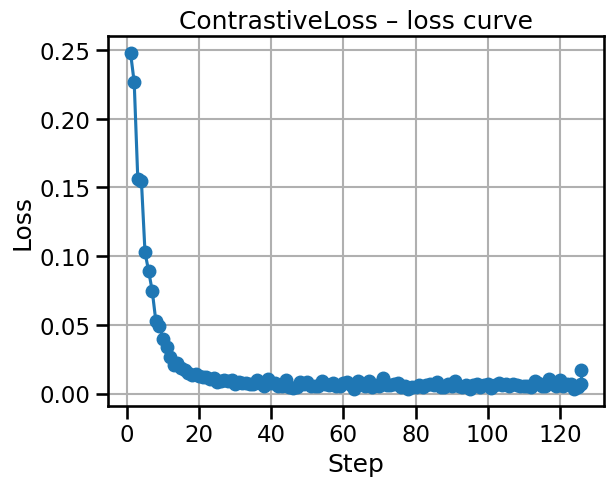

In [147]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)


# Pick loss class dynamically
loss_cls = losses.ContrastiveLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "contrastiveloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="contrastiveloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="ContrastiveLoss – loss curve")

initial  : within=0.4421   between=0.9680 sil=0.620
trained  : within=0.0312   between=0.9230   sil=0.964
trained2 : within=0.7079   between=0.2430  sil=0.036


<Axes: title={'center': 'label encoding (sentence2)'}, xlabel='PC1', ylabel='PC2'>

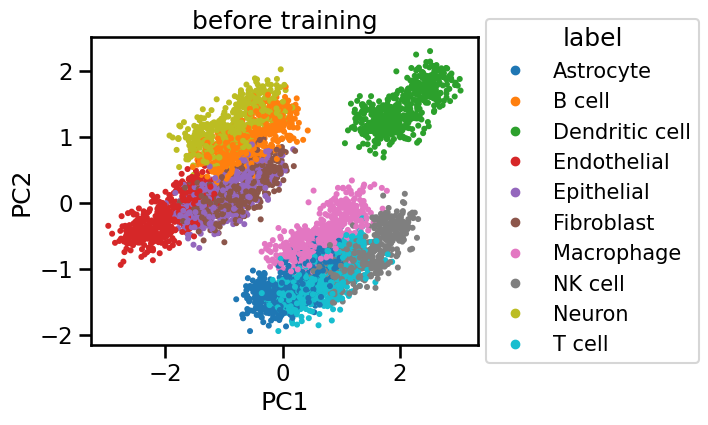

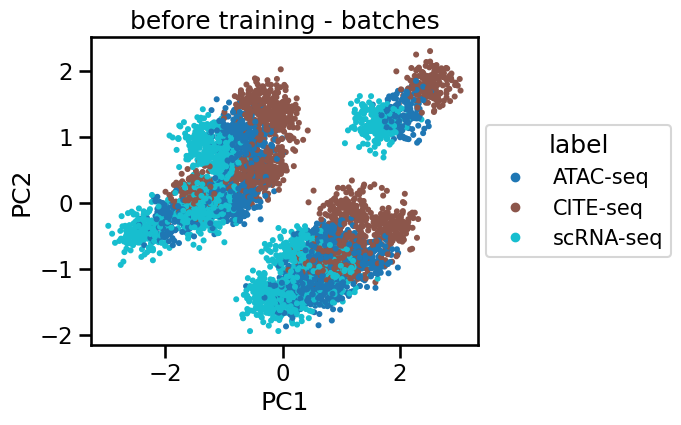

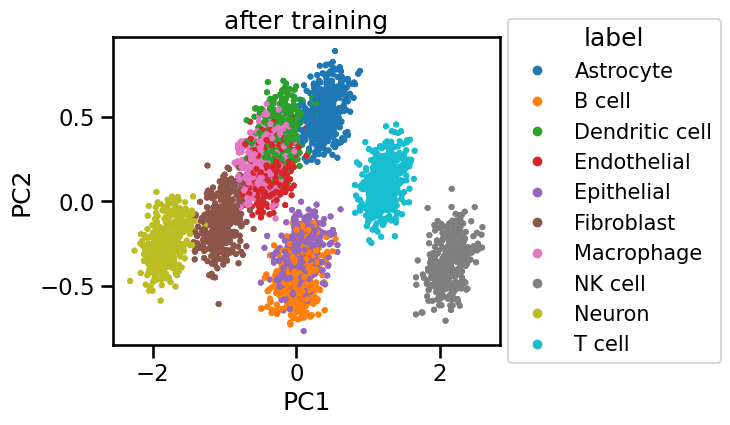

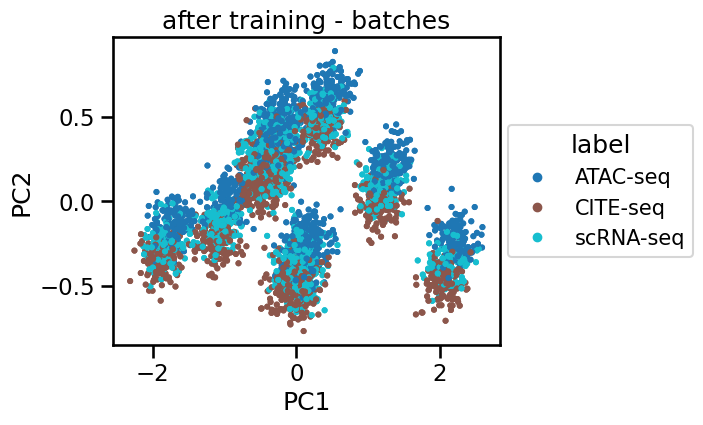

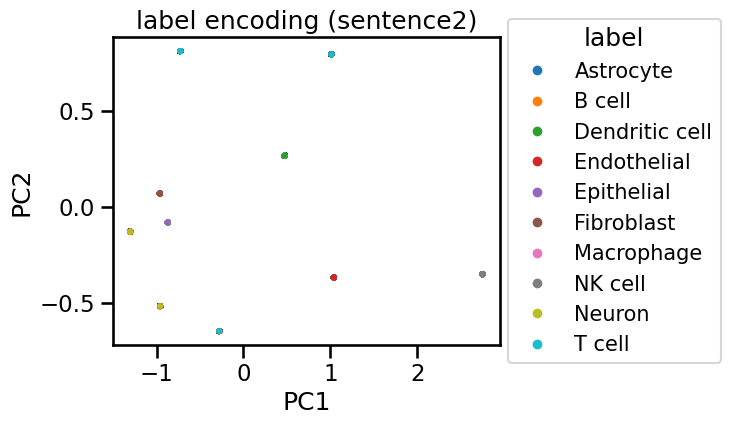

In [148]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset pair-binary")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)
new_emb2 = model.encode(train_ds["sentence2"], convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)
within2, between2, sil2 = cluster_variances(new_emb2, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")
print(f"trained2 : within={within2:.4f}   between={between2:.4f}  sil={sil2:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)
R_new2 = rng.standard_normal((new_emb2.shape[1], 2))
R_new2 /= np.linalg.norm(R_new2, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)
plot_pca(new_emb2 @ R_new2, labels, title="label encoding (sentence2)", point_size=8, legend_out=True)

## 4.5 BatchAllTripletLoss
Generates *all* valid triplets in a batch and averages over them.

*Dataset used:* **single-class**

In [149]:
# --- BatchAllTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence  label sample_idx
0  sample_idx:S1      8         S1
1  sample_idx:S2      5         S2
2  sample_idx:S3      4         S3
3  sample_idx:S5      6         S5
4  sample_idx:S6      9         S6

2025-05-16 15:48:06,735 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:48:06,736 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:48:06,738 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 20%|██        | 13/64 [00:00<00:00, 57.77it/s]                      

{'loss': 1.454, 'grad_norm': 6.8040289878845215, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 0.7769, 'grad_norm': 7.673107147216797, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 0.3297, 'grad_norm': 12.655828475952148, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.2829, 'grad_norm': 13.236708641052246, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00828125, 'epoch': 0.34}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.008125, 'epoch': 0.38}
{'loss': 0.0, 'gra

 38%|███▊      | 24/64 [00:00<00:00, 54.19it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0078125, 'epoch': 0.44}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00765625, 'epoch': 0.47}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.265, 'grad_norm': 11.0723295211792, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00625, 'epoch': 0.75}


 55%|█████▍    | 35/64 [00:00<00:00, 52.68it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.1291, 'grad_norm': 10.659252166748047, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0054687500000000005, 'epoch': 0.91}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0053125, 'epoch': 0.94}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00453125, 'epoch': 1.09}


 70%|███████   | 45/64 [00:00<00:00, 50.11it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00296875, 'epoch': 1.41}


 92%|█████████▏| 59/64 [00:01<00:00, 58.03it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0028125, 'epoch': 1.44}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.0, 'grad_norm':

100%|██████████| 64/64 [00:01<00:00, 57.22it/s]2025-05-16 15:48:08,165 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/batchalltripletloss_20250516_154806/checkpoint-64
2025-05-16 15:48:08,165 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/batchalltripletloss_20250516_154806/checkpoint-64


{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:02<00:00, 28.95it/s]

{'train_runtime': 2.2118, 'train_samples_per_second': 3616.985, 'train_steps_per_second': 28.936, 'train_loss': 0.05058775097131729, 'epoch': 2.0}


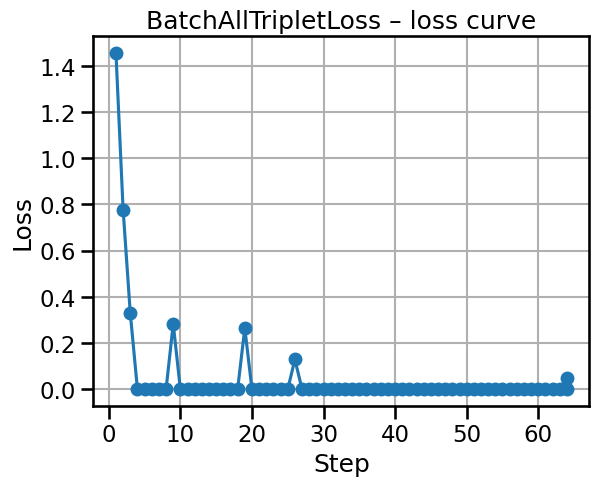

In [150]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchAllTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchalltripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchalltripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="BatchAllTripletLoss – loss curve")

initial  : within=0.4421   between=0.9680 sil=0.620
trained  : within=0.0551   between=1.0312   sil=0.936


<Axes: title={'center': 'after training - batches'}, xlabel='PC1', ylabel='PC2'>

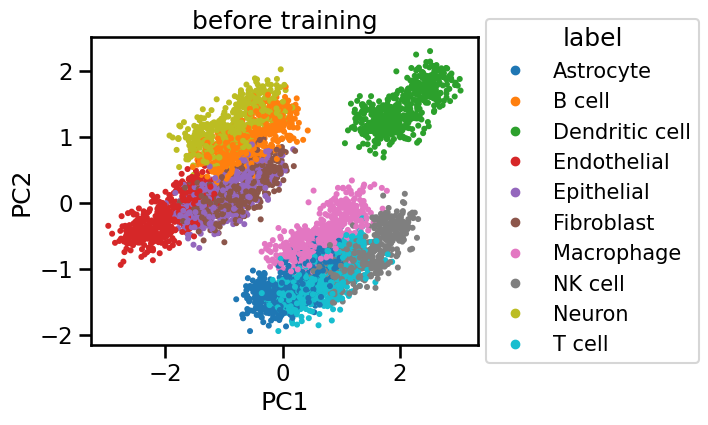

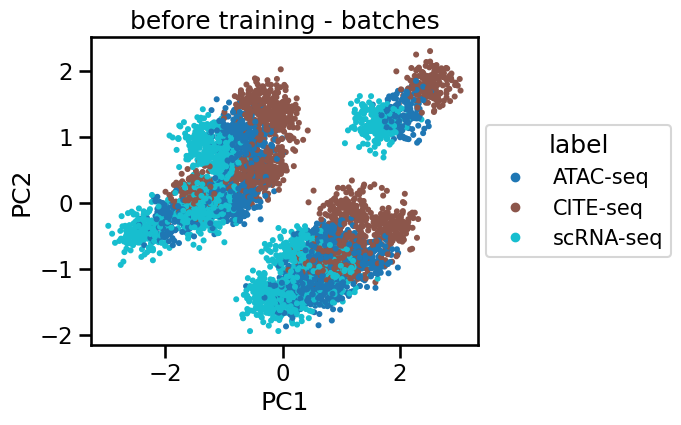

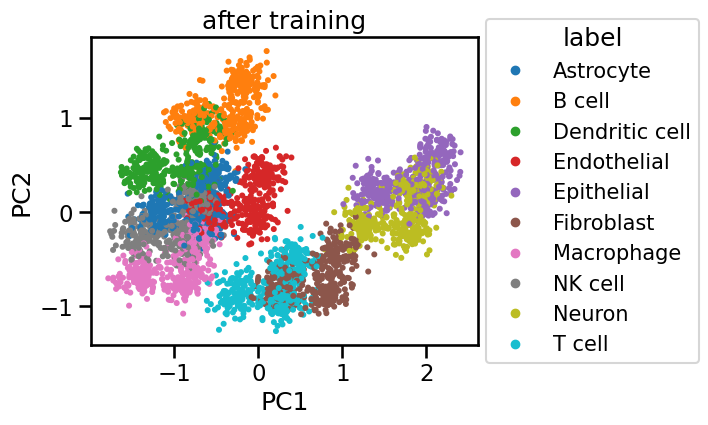

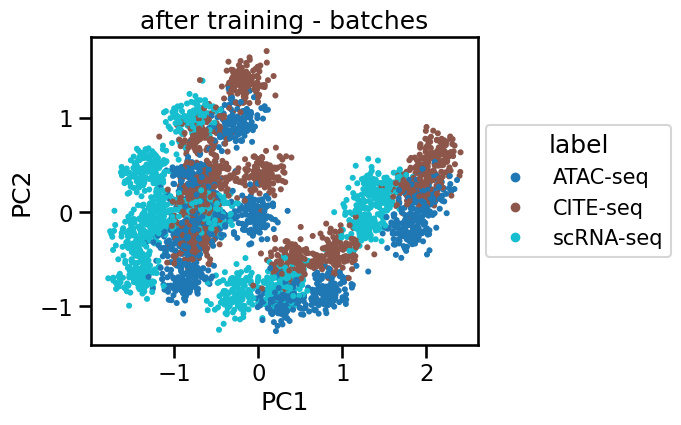

In [152]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)

## 4.6 BatchHardTripletLoss
Selects hardest positive & negative per anchor in batch (faceNet style).

*Dataset used:* **single-class**

In [ ]:
# --- BatchHardTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence  label sample_idx
0  sample_idx:S1      8         S1
1  sample_idx:S2      5         S2
2  sample_idx:S3      4         S3
3  sample_idx:S5      6         S5
4  sample_idx:S6      9         S6

2025-05-16 15:55:44,636 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:55:44,637 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:55:44,639 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 25%|██▌       | 16/64 [00:00<00:00, 74.70it/s]                      

{'loss': 3.6615, 'grad_norm': 8.082788467407227, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 0.7756, 'grad_norm': 4.724857330322266, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 0.0043, 'grad_norm': 0.10337025672197342, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.0111, 'grad_norm': 0.44901248812675476, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.0006, 'grad_norm': 0.10778003931045532, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.0003, 'grad_norm': 0.1143822968006134, 'learning_rate': 0.00828125, 'epoch': 0.34}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00

 50%|█████     | 32/64 [00:00<00:00, 79.12it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0054687500000000005, 'epo

 75%|███████▌  | 48/64 [00:00<00:00, 78.43it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.0013, 'grad_norm': 0.09093767404556274, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'l

 98%|█████████▊| 63/64 [00:00<00:00, 76.26it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 0.0, 'grad_no

100%|██████████| 64/64 [00:00<00:00, 76.26it/s]2025-05-16 15:55:45,757 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/batchhardtripletloss_20250516_155544/checkpoint-64
2025-05-16 15:55:45,757 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/batchhardtripletloss_20250516_155544/checkpoint-64


{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:01<00:00, 33.96it/s]

{'train_runtime': 1.8856, 'train_samples_per_second': 4242.749, 'train_steps_per_second': 33.942, 'train_loss': 0.06969574803952128, 'epoch': 2.0}


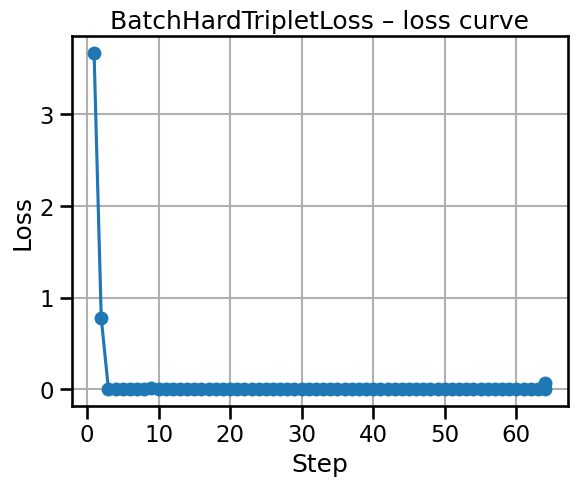

In [153]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchHardTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchhardtripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchhardtripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="BatchHardTripletLoss – loss curve")

initial  : within=0.4421   between=0.9680 sil=0.620
trained  : within=0.1016   between=0.9725   sil=0.888


<Axes: title={'center': 'after training - batches'}, xlabel='PC1', ylabel='PC2'>

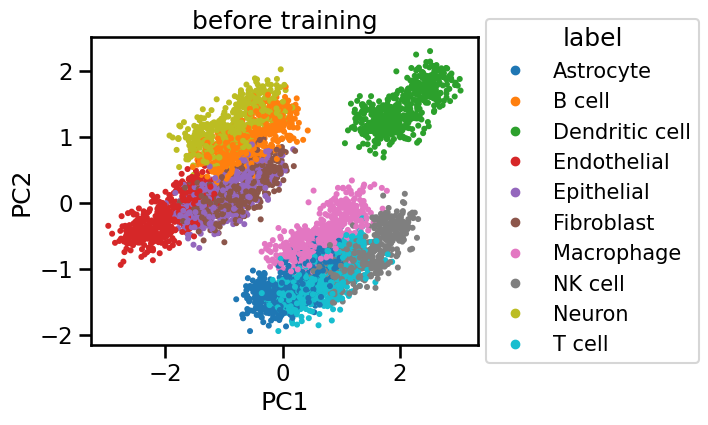

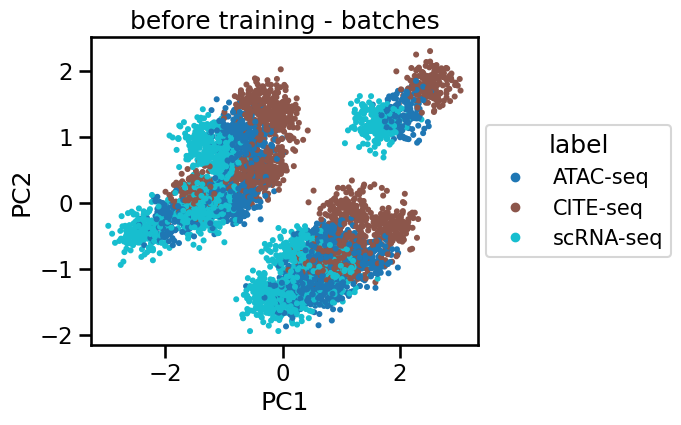

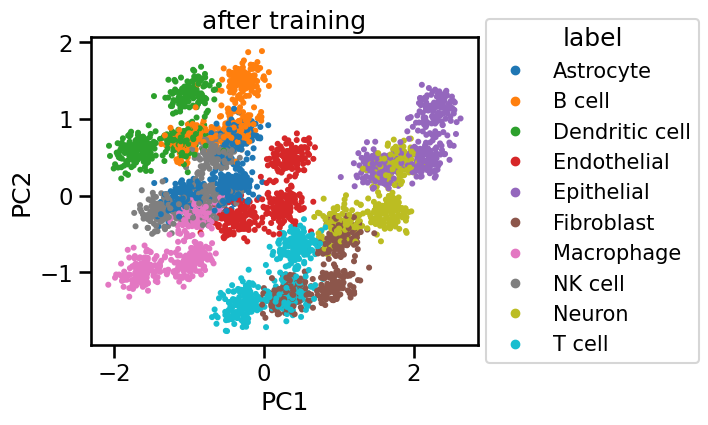

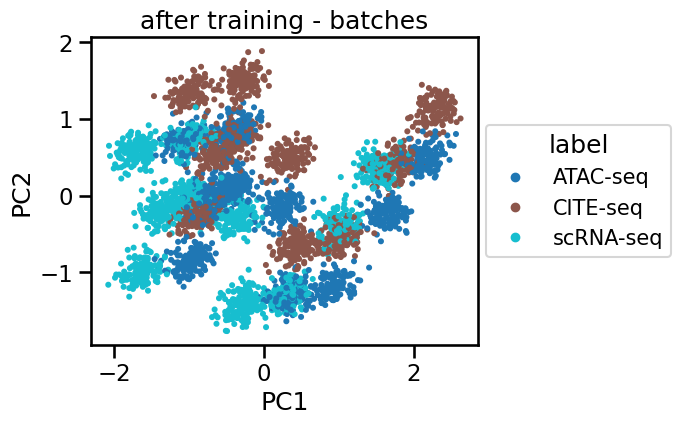

In [154]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)


print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)

## 4.7 BatchSemiHardTripletLoss
Like ‘hard’ but excludes positives that are further away than the hardest negatives.

*Dataset used:* **single-class**

In [155]:
# --- BatchSemiHardTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence  label sample_idx
0  sample_idx:S1      8         S1
1  sample_idx:S2      5         S2
2  sample_idx:S3      4         S3
3  sample_idx:S5      6         S5
4  sample_idx:S6      9         S6

2025-05-16 15:56:10,824 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:56:10,825 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:56:10,827 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 23%|██▎       | 15/64 [00:00<00:00, 65.06it/s]                      

{'loss': 1.8485, 'grad_norm': 4.455812931060791, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 0.2732, 'grad_norm': 2.1964468955993652, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.004, 'grad_norm': 0.10163424164056778, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.0159, 'grad_norm': 0.5167827606201172, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.0004, 'grad_norm': 0.029660750180482864, 'learning_rate': 0.00828125, 'epoch': 0.34}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.008125, 'epoch': 0.3

 47%|████▋     | 30/64 [00:00<00:00, 70.48it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0075, 'epoch': 0.5}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0073437500000000005, 'epoch': 0.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0071875, 'epoch': 0.56}
{'loss': 0.0, 'grad_norm': 0.014472848735749722, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.0, 'grad_norm': 0.008590367622673512, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rat

 72%|███████▏  | 46/64 [00:00<00:00, 73.41it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00515625, 'epoch': 0.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.005, 'epoch': 1.0}
{'loss': 0.0001, 'grad_norm': 0.008202220313251019, 'learning_rate': 0.00484375, 'epoch': 1.03}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0046875, 'epoch': 1.06}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00453125, 'epoch': 1.09}
{'loss': 0.0001, 'grad_norm': 0.008159146644175053, 'learning_rate': 0.004375, 'epoch': 1.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0, 'grad_norm': 0.008247367106378078, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rat

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00265625, 'epoch': 1.47}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0025, 'epoch': 1.5}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00234375, 'epoch': 1.53}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0021875, 'epoch': 1.56}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00203125, 'epoch': 1.59}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.001875, 'epoch': 1.62}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00171875, 'epoch': 1.66}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 0.0, 'grad_norm'

100%|██████████| 64/64 [00:00<00:00, 71.97it/s]2025-05-16 15:56:12,046 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/batchsemihardtripletloss_20250516_155610/checkpoint-64
2025-05-16 15:56:12,046 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/batchsemihardtripletloss_20250516_155610/checkpoint-64


{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 0.0, 'grad_norm': 0.007069070357829332, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 64/64 [00:01<00:00, 32.81it/s]

{'train_runtime': 1.9513, 'train_samples_per_second': 4099.77, 'train_steps_per_second': 32.798, 'train_loss': 0.03349612690607273, 'epoch': 2.0}


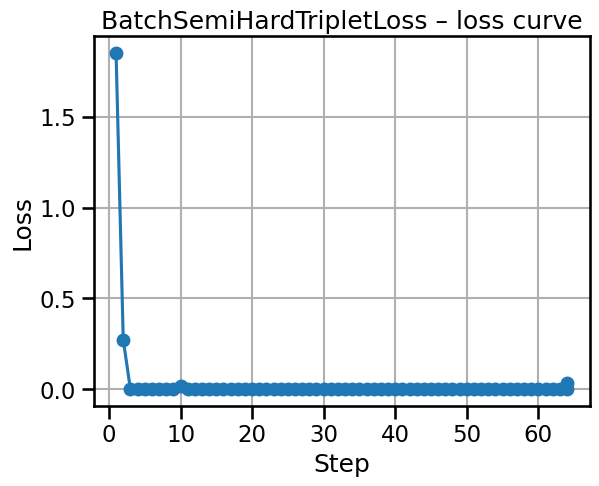

In [156]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchSemiHardTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchsemihardtripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchsemihardtripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="BatchSemiHardTripletLoss – loss curve")

initial  : within=0.4421   between=0.9680  sil=0.620
trained  : within=0.1096   between=0.9562   sil=0.877


<Axes: title={'center': 'after training - batches'}, xlabel='PC1', ylabel='PC2'>

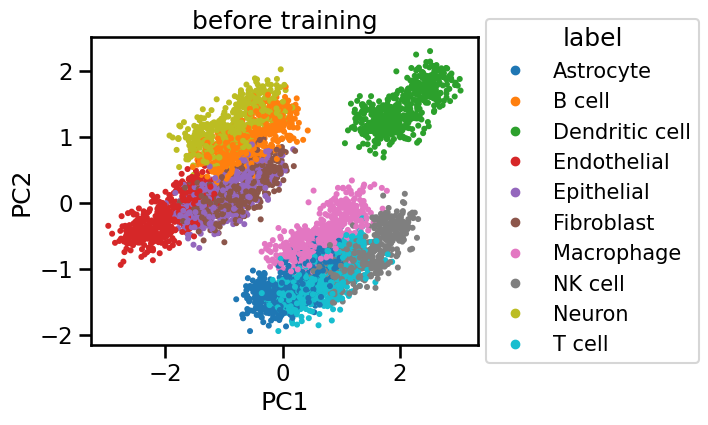

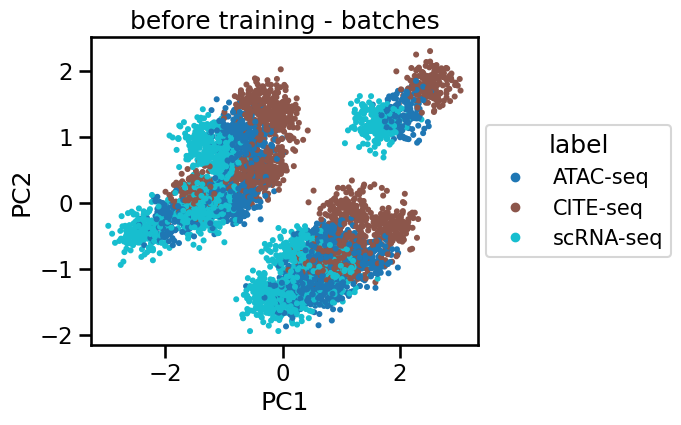

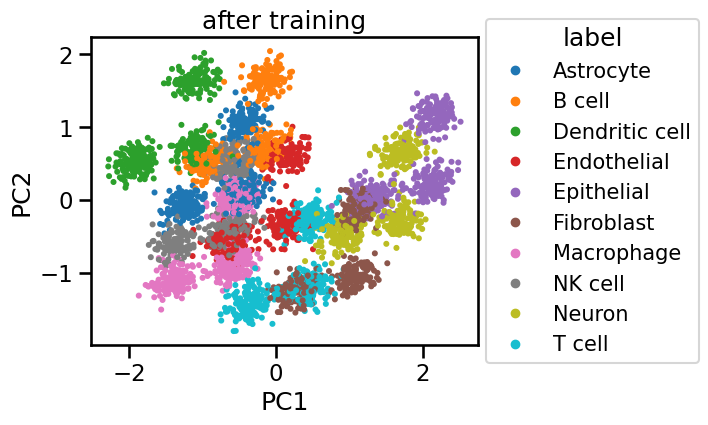

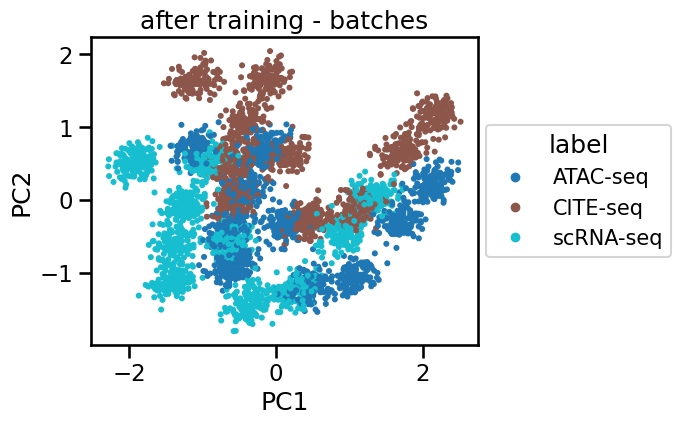

In [157]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
    batches = sim.adata.obs["assay"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f}  sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)

## 4.8 BatchHardSoftMarginTripletLoss
Hard triplet mining combined with a soft‑margin formulation.

*Dataset used:* **single-class**

In [158]:
# --- BatchHardSoftMarginTripletLoss: preview dataset -------------------------------------------------
train_ds = hf_datasets["single-class"]["train"]
display(pd.DataFrame(train_ds[:5]))

sentence  label sample_idx
0  sample_idx:S1      8         S1
1  sample_idx:S2      5         S2
2  sample_idx:S3      4         S3
3  sample_idx:S5      6         S5
4  sample_idx:S6      9         S6

2025-05-16 15:56:25,985 - mmcontext.models.MiniOmicsEncoder - INFO - Loaded embedding matrix with shape (5001, 32)
2025-05-16 15:56:25,986 - mmcontext.mmcontextencoder - INFO - Registered 5001 new numeric samples (total 5001). ≈0.001 GiB added. (Assuming float32 precision.)
2025-05-16 15:56:25,987 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
 30%|██▉       | 19/64 [00:00<00:00, 88.54it/s]                      

{'loss': 0.3865, 'grad_norm': 2.5607707500457764, 'learning_rate': 0.00984375, 'epoch': 0.03}
{'loss': 0.025, 'grad_norm': 0.18667513132095337, 'learning_rate': 0.0096875, 'epoch': 0.06}
{'loss': 0.0041, 'grad_norm': 0.030283045023679733, 'learning_rate': 0.00953125, 'epoch': 0.09}
{'loss': 0.0017, 'grad_norm': 0.01312950998544693, 'learning_rate': 0.009375, 'epoch': 0.12}
{'loss': 0.001, 'grad_norm': 0.008167987689375877, 'learning_rate': 0.00921875, 'epoch': 0.16}
{'loss': 0.0008, 'grad_norm': 0.007209747564047575, 'learning_rate': 0.0090625, 'epoch': 0.19}
{'loss': 0.0008, 'grad_norm': 0.007297528441995382, 'learning_rate': 0.008906250000000001, 'epoch': 0.22}
{'loss': 0.0009, 'grad_norm': 0.008980175480246544, 'learning_rate': 0.00875, 'epoch': 0.25}
{'loss': 0.0013, 'grad_norm': 0.013063683174550533, 'learning_rate': 0.00859375, 'epoch': 0.28}
{'loss': 0.0015, 'grad_norm': 0.014456765726208687, 'learning_rate': 0.0084375, 'epoch': 0.31}
{'loss': 0.0014, 'grad_norm': 0.012460195459

 56%|█████▋    | 36/64 [00:00<00:00, 87.84it/s]

{'loss': 0.0013, 'grad_norm': 0.01075320690870285, 'learning_rate': 0.00703125, 'epoch': 0.59}
{'loss': 0.0009, 'grad_norm': 0.00712509173899889, 'learning_rate': 0.006875, 'epoch': 0.62}
{'loss': 0.001, 'grad_norm': 0.00779676903039217, 'learning_rate': 0.00671875, 'epoch': 0.66}
{'loss': 0.0008, 'grad_norm': 0.006564428098499775, 'learning_rate': 0.0065625, 'epoch': 0.69}
{'loss': 0.0008, 'grad_norm': 0.006301160901784897, 'learning_rate': 0.0064062500000000005, 'epoch': 0.72}
{'loss': 0.0006, 'grad_norm': 0.004592771176248789, 'learning_rate': 0.00625, 'epoch': 0.75}
{'loss': 0.0005, 'grad_norm': 0.004166357219219208, 'learning_rate': 0.00609375, 'epoch': 0.78}
{'loss': 0.0005, 'grad_norm': 0.004147746134549379, 'learning_rate': 0.0059375, 'epoch': 0.81}
{'loss': 0.0004, 'grad_norm': 0.003302139462903142, 'learning_rate': 0.00578125, 'epoch': 0.84}
{'loss': 0.0005, 'grad_norm': 0.0036486033350229263, 'learning_rate': 0.005625, 'epoch': 0.88}
{'loss': 0.0004, 'grad_norm': 0.002990551

 83%|████████▎ | 53/64 [00:00<00:00, 86.65it/s]

{'loss': 0.0002, 'grad_norm': 0.0016259548719972372, 'learning_rate': 0.00421875, 'epoch': 1.16}
{'loss': 0.0003, 'grad_norm': 0.002098986180499196, 'learning_rate': 0.0040625, 'epoch': 1.19}
{'loss': 0.0003, 'grad_norm': 0.001987410243600607, 'learning_rate': 0.00390625, 'epoch': 1.22}
{'loss': 0.0002, 'grad_norm': 0.0016818102449178696, 'learning_rate': 0.00375, 'epoch': 1.25}
{'loss': 0.0003, 'grad_norm': 0.00238489150069654, 'learning_rate': 0.00359375, 'epoch': 1.28}
{'loss': 0.0002, 'grad_norm': 0.001631888677366078, 'learning_rate': 0.0034375, 'epoch': 1.31}
{'loss': 0.0002, 'grad_norm': 0.0016206603031605482, 'learning_rate': 0.00328125, 'epoch': 1.34}
{'loss': 0.0003, 'grad_norm': 0.0020722041372209787, 'learning_rate': 0.003125, 'epoch': 1.38}
{'loss': 0.0002, 'grad_norm': 0.0015457489062100649, 'learning_rate': 0.00296875, 'epoch': 1.41}
{'loss': 0.0002, 'grad_norm': 0.0018337778747081757, 'learning_rate': 0.0028125, 'epoch': 1.44}
{'loss': 0.0002, 'grad_norm': 0.00182035646

100%|██████████| 64/64 [00:00<00:00, 84.43it/s]2025-05-16 15:56:27,018 - sentence_transformers.trainer - INFO - Saving model checkpoint to models/report/batchhardsoftmargintripletloss_20250516_155626/checkpoint-64
2025-05-16 15:56:27,019 - sentence_transformers.SentenceTransformer - INFO - Save model to models/report/batchhardsoftmargintripletloss_20250516_155626/checkpoint-64


{'loss': 0.0002, 'grad_norm': 0.001194305601529777, 'learning_rate': 0.0015625, 'epoch': 1.69}
{'loss': 0.0002, 'grad_norm': 0.001476286561228335, 'learning_rate': 0.00140625, 'epoch': 1.72}
{'loss': 0.0002, 'grad_norm': 0.001042859279550612, 'learning_rate': 0.00125, 'epoch': 1.75}
{'loss': 0.0002, 'grad_norm': 0.0011911726323887706, 'learning_rate': 0.00109375, 'epoch': 1.78}
{'loss': 0.0002, 'grad_norm': 0.0011592934606596828, 'learning_rate': 0.0009375, 'epoch': 1.81}
{'loss': 0.0002, 'grad_norm': 0.0010574772022664547, 'learning_rate': 0.00078125, 'epoch': 1.84}
{'loss': 0.0002, 'grad_norm': 0.0012232816079631448, 'learning_rate': 0.000625, 'epoch': 1.88}
{'loss': 0.0001, 'grad_norm': 0.00103560381103307, 'learning_rate': 0.00046875, 'epoch': 1.91}
{'loss': 0.0002, 'grad_norm': 0.0014080229448154569, 'learning_rate': 0.0003125, 'epoch': 1.94}
{'loss': 0.0002, 'grad_norm': 0.0012337465304881334, 'learning_rate': 0.00015625, 'epoch': 1.97}
{'loss': 0.0001, 'grad_norm': 0.00103586341

100%|██████████| 64/64 [00:01<00:00, 35.59it/s]

{'train_runtime': 1.7992, 'train_samples_per_second': 4446.448, 'train_steps_per_second': 35.572, 'train_loss': 0.007029840598988812, 'epoch': 2.0}


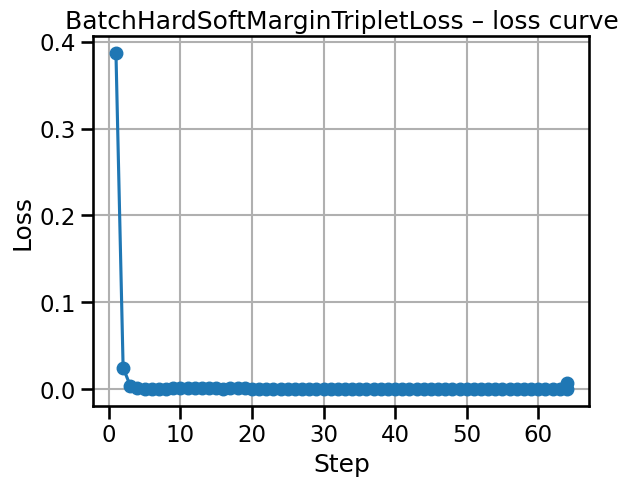

In [159]:
from sentence_transformers import losses  # re‑import inside each cell for clarity

# Fresh model copy to avoid weight carry‑over
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)
enc.register_initial_embeddings(sample_df, data_origin="pca")
model = SentenceTransformer(modules=[enc]).to(DEVICE)

# Pick loss class dynamically
loss_cls = losses.BatchHardSoftMarginTripletLoss
loss_fn = loss_cls(model).to(DEVICE)

out_dir = get_output_dir("./models/report", "batchhardsoftmargintripletloss")
args = SentenceTransformerTrainingArguments(
    output_dir=str(out_dir),
    run_name="batchhardsoftmargintripletloss",
    **TRAIN_KW,
)

# Remove sample_idx if present (need later for label recovery)
if "sample_idx" in train_ds.column_names:
    sample_idx = train_ds["sample_idx"]
    train_no_idx = train_ds.remove_columns(["sample_idx"])
else:
    sample_idx = None
    train_no_idx = train_ds

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_no_idx,
    loss=loss_fn,
)
trainer.train()

plot_training_loss(trainer, title="BatchHardSoftMarginTripletLoss – loss curve")

initial  : within=0.4421   between=0.9680 sil=0.620
trained  : within=0.0824   between=0.9912   sil=0.914


<Axes: title={'center': 'after training - batches'}, xlabel='PC1', ylabel='PC2'>

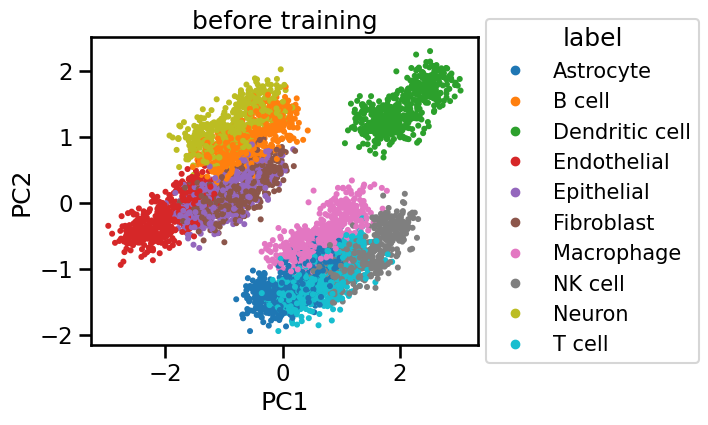

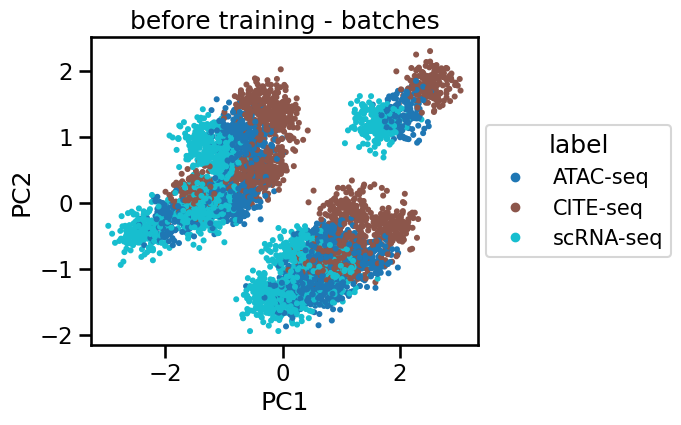

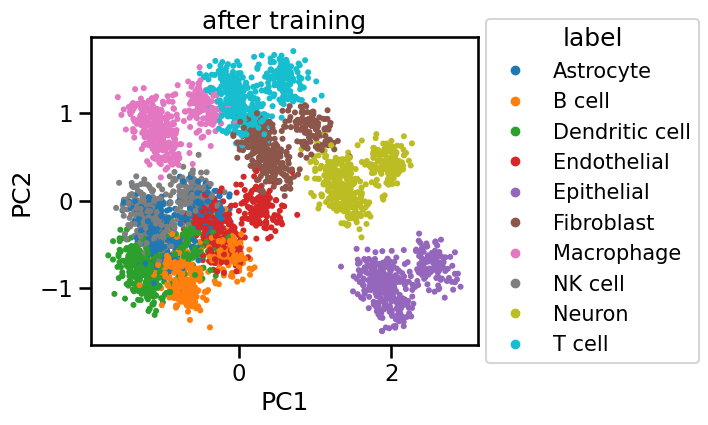

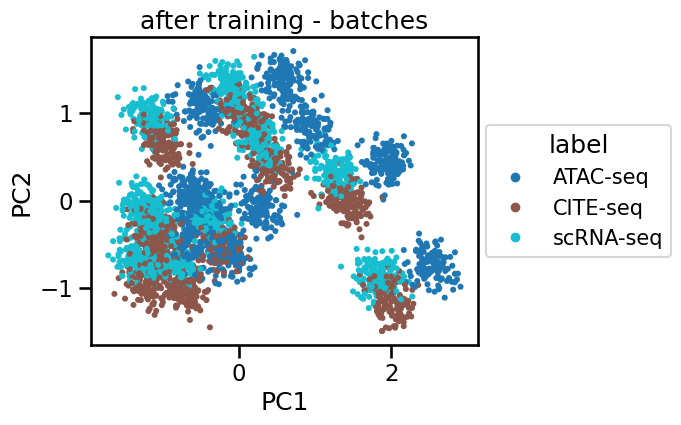

In [160]:
# -------- Evaluate embedding quality -------------
# Determine primary text column adaptively
cols = train_ds.column_names
if "anchor" in cols:
    primary_sent = train_ds["anchor"]
elif "sentence1" in cols:
    primary_sent = train_ds["sentence1"]
elif "sentence" in cols:
    primary_sent = train_ds["sentence"]
else:
    raise ValueError("Unknown primary sentence column for preset single-class")

new_emb = model.encode(primary_sent, convert_to_numpy=True, batch_size=256, show_progress_bar=False)

# Recover labels
if sample_idx is not None:
    labels = sim.adata.obs["cell_type"][sample_idx]
elif "label" in cols and train_ds.features["label"].int2str is not None:
    labels = train_ds.features["label"].int2str(train_ds["label"])
else:
    labels = ["unknown"] * len(primary_sent)

# Variance metrics
within0, between0, sil0 = cluster_variances(old_emb, old_labels, return_silhouette=True)
within1, between1, sil1 = cluster_variances(new_emb, labels, return_silhouette=True)

print(f"initial  : within={within0:.4f}   between={between0:.4f} sil={sil0:.3f}")
print(f"trained  : within={within1:.4f}   between={between1:.4f}   sil={sil1:.3f}")

# Random 2‑D projection
rng = np.random.default_rng(42)
R_old = rng.standard_normal((old_emb.shape[1], 2))
R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
R_new = rng.standard_normal((new_emb.shape[1], 2))
R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

plot_pca(old_emb @ R_old, old_labels, title="before training", point_size=8, legend_out=True)
plot_pca(old_emb @ R_old, batch_labels, title="before training - batches", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, labels, title="after training", point_size=8, legend_out=True)
plot_pca(new_emb @ R_new, batches, title="after training - batches", point_size=8, legend_out=True)

In [162]:
import logging
from collections.abc import Iterable

import numpy as np
from scipy.spatial import procrustes
from sklearn.decomposition import PCA

logger = logging.getLogger(__name__)


def shared_linear_projection(
    arrays: Iterable[np.ndarray],
    n_out: int = 2,
    common_dim: int | None = None,
    align: bool = True,
    random_state: int | None = 0,
) -> list[np.ndarray]:
    """
    Project several embedding matrices into **one common low-D space**.

    Parameters
    ----------
    arrays
        Iterable of shape-(n_i, d_i) arrays.  All must have the *same
        number of rows* (samples) but can differ in embedding dimension.
    n_out
        Target dimensionality (e.g., 2 for plotting).
    common_dim
        Intermediate dimensionality *k*.  If ``None`` use
        ``min(d_i)``.  All arrays are reduced to *k* by PCA if needed.
    align
        If *True*, perform an orthogonal Procrustes alignment so that
        sign flips between PCAs cannot confuse the eye.
    random_state
        Passed to all PCA instances for reproducibility.

    Returns
    -------
    coords : list[np.ndarray]
        List of shape-(n_i, n_out) arrays—**all in the same basis**.

    Notes
    -----
    *Data source*: the arrays you pass in (simulated and learned embeddings).

    Example
    -------
    >>> X0, X1, X2 = old_emb, new_emb, new_emb2
    >>> X0c, X1c, X2c = shared_linear_projection([X0, X1, X2])
    """
    arrays = list(arrays)
    n_samples = {a.shape[0] for a in arrays}
    if len(n_samples) != 1:
        raise ValueError("All arrays must have the same number of rows (samples).")

    # -------- 1) equalise dimensionality ----------------------------------
    if common_dim is None:
        common_dim = min(a.shape[1] for a in arrays)
    logger.info("Reducing all embeddings to common_dim=%d", common_dim)

    reduced: list[np.ndarray] = []
    for _i, A in enumerate(arrays):
        if A.shape[1] > common_dim:
            pca_red = PCA(n_components=common_dim, random_state=random_state)
            A_red = pca_red.fit_transform(A)
            reduced.append(A_red)
        elif A.shape[1] < common_dim:
            # zero-pad to the right
            padding = np.zeros((A.shape[0], common_dim - A.shape[1]), dtype=A.dtype)
            reduced.append(np.hstack([A, padding]))
        else:
            reduced.append(A)

    # -------- 2) one PCA on the union -------------------------------------
    union = np.vstack(reduced)
    pca = PCA(n_components=n_out, random_state=random_state)
    pca.fit(union)

    coords = [pca.transform(A) for A in reduced]

    # -------- 3) optional Procrustes to fix sign / rotation ---------------
    if align and len(coords) > 1:
        ref = coords[0]
        coords = [ref] + [procrustes(ref, C)[1] for C in coords[1:]]  # keeps scale = 1

    return coords

In [163]:
xs = shared_linear_projection([old_emb, new_emb, new_emb2], n_out=2)
plot_pca(xs[0], labels, title="raw (common space)")
plot_pca(xs[1], labels, title="trained (common space)")
plot_pca(xs[2], labels, title="one-hot (common space)")

ValueError: All arrays must have the same number of rows (samples).

## 5. Run summary (fill during execution)

In [129]:
# Users can append rows manually or programmatically here
